### Imports

In [1]:
import nltk
from nltk.corpus import reuters
import pandas as pd
import re

from nltk.stem.porter import PorterStemmer

from gensim.corpora import Dictionary
from gensim.models import LsiModel, LdaModel
from gensim.models import CoherenceModel
from gensim.models import TfidfModel
from gensim.models.phrases import Phrases, Phraser

from nltk.corpus import stopwords
#import nltk
#nltk.download('stopwords')
import spacy

In [2]:
nltk.download('reuters')
files = reuters.fileids()
dados = []

for file_id in files:
    categorias = reuters.categories(file_id)
    texto = reuters.raw(file_id)
    dados.append({
        "file_id": file_id,
        "categorias": ", ".join(categorias),
        "texto": texto
    })

df = pd.DataFrame(dados)
df.to_csv("reuters.csv", index=False, encoding="utf-8")

[nltk_data] Downloading package reuters to
[nltk_data]     C:\Users\strik\AppData\Roaming\nltk_data...
[nltk_data]   Package reuters is already up-to-date!


In [3]:
df_reuters = pd.read_csv('reuters.csv')
df_random_samples = pd.read_csv('random_reuters_samples.csv')

print(f"Number of rows in reuters.csv: {len(df_reuters)}")
print(f"Number of rows in random_reuters_samples.csv: {len(df_random_samples)}")

Number of rows in reuters.csv: 10788
Number of rows in random_reuters_samples.csv: 10


### Análise Exploratória

In [4]:
reuters = pd.read_csv('reuters.csv')

In [5]:
reuters.head()

file_id                                    categorias  \
0  test/14826                                         trade   
1  test/14828                                         grain   
2  test/14829                                crude, nat-gas   
3  test/14832  corn, grain, rice, rubber, sugar, tin, trade   
4  test/14833                             palm-oil, veg-oil   

                                               texto  
0  ASIAN EXPORTERS FEAR DAMAGE FROM U.S.-JAPAN RI...  
1  CHINA DAILY SAYS VERMIN EAT 7-12 PCT GRAIN STO...  
2  JAPAN TO REVISE LONG-TERM ENERGY DEMAND DOWNWA...  
3  THAI TRADE DEFICIT WIDENS IN FIRST QUARTER\n  ...  
4  INDONESIA SEES CPO PRICE RISING SHARPLY\n  Ind...

In [6]:
reuters.describe()

file_id categorias                           texto
count        10788      10788                           10788
unique       10788        468                           10657
top     test/14826       earn  26-FEB-1987\n  26-FEB-1987\n\n
freq             1       3923                               7

In [7]:
categories = set()

for item in reuters["categorias"]:
    
    parts = item.split(",")
    
    for p in parts:
        p_clean = p.strip()
        if p_clean != "":
            categories.add(p_clean)
print(len(categories))

90


In [8]:
categories

{'acq',
 'alum',
 'barley',
 'bop',
 'carcass',
 'castor-oil',
 'cocoa',
 'coconut',
 'coconut-oil',
 'coffee',
 'copper',
 'copra-cake',
 'corn',
 'cotton',
 'cotton-oil',
 'cpi',
 'cpu',
 'crude',
 'dfl',
 'dlr',
 'dmk',
 'earn',
 'fuel',
 'gas',
 'gnp',
 'gold',
 'grain',
 'groundnut',
 'groundnut-oil',
 'heat',
 'hog',
 'housing',
 'income',
 'instal-debt',
 'interest',
 'ipi',
 'iron-steel',
 'jet',
 'jobs',
 'l-cattle',
 'lead',
 'lei',
 'lin-oil',
 'livestock',
 'lumber',
 'meal-feed',
 'money-fx',
 'money-supply',
 'naphtha',
 'nat-gas',
 'nickel',
 'nkr',
 'nzdlr',
 'oat',
 'oilseed',
 'orange',
 'palladium',
 'palm-oil',
 'palmkernel',
 'pet-chem',
 'platinum',
 'potato',
 'propane',
 'rand',
 'rape-oil',
 'rapeseed',
 'reserves',
 'retail',
 'rice',
 'rubber',
 'rye',
 'ship',
 'silver',
 'sorghum',
 'soy-meal',
 'soy-oil',
 'soybean',
 'strategic-metal',
 'sugar',
 'sun-meal',
 'sun-oil',
 'sunseed',
 'tea',
 'tin',
 'trade',
 'veg-oil',
 'wheat',
 'wpi',
 'yen',
 'zinc'}

Pré-Processamento Simples

In [9]:
def preprocess_dataframe(df, text_column="texto"):
    df = df.copy()

    df[text_column] = (
        df[text_column]
        .astype(str)
        .str.lower()
        .apply(lambda x: re.sub(r"[^a-z\s]", " ", x))
        .apply(lambda x: re.sub(r"\s+", " ", x).strip())
    )

    return df

In [10]:
df_simple = preprocess_dataframe(reuters, text_column="texto")
df_simple.head()

file_id                                    categorias  \
0  test/14826                                         trade   
1  test/14828                                         grain   
2  test/14829                                crude, nat-gas   
3  test/14832  corn, grain, rice, rubber, sugar, tin, trade   
4  test/14833                             palm-oil, veg-oil   

                                               texto  
0  asian exporters fear damage from u s japan rif...  
1  china daily says vermin eat pct grain stocks a...  
2  japan to revise long term energy demand downwa...  
3  thai trade deficit widens in first quarter tha...  
4  indonesia sees cpo price rising sharply indone...

Separação dos 10 Documentos

In [11]:
df_simple10 = df_simple.sample(10, random_state=42)
df_simple = df_simple.drop(df_simple10.index).reset_index(drop=True)

print("Linhas no df_simple (original):", len(df_simple))
print("Linhas no df_reserved (10 docs):", len(df_simple10))
df_simple10.head()

Linhas no df_simple (original): 10778
Linhas no df_reserved (10 docs): 10


file_id categorias  \
4593   training/12421       earn   
8353    training/6220       earn   
3614   training/10921       earn   
10382   training/9348       ship   
8048    training/5707       earn   

                                                   texto  
4593   bayer world group pre tax profit billion marks...  
8353   marcor lt maar expects fiscal year profit marc...  
3614   computer microfilm corp lt comi year net shr c...  
10382  iran says has better weapons than silkworm ira...  
8048   transamerica income lt tai monthly dividend sh...

### String and tokenize

In [12]:
df_simple['texto'] = df_simple['texto'].astype(str)
documents = df_simple['texto'].apply(str.split).tolist()

### Dictionay and Bag-of-Words

### Model 1

In [13]:
dictionary = Dictionary(documents)
doc_term_matrix = [dictionary.doc2bow(doc) for doc in documents]

### Defs para Modelos

In [14]:
def LSA_model(doc_term_matrix, num_topics = 90, dictionary = dictionary):
    lsi_model = LsiModel(doc_term_matrix, num_topics, id2word=dictionary)
    return lsi_model

def LDA_model(doc_term_matrix, num_topics=90, dictionary=dictionary):

    lda_model = LdaModel(doc_term_matrix,num_topics, id2word=dictionary)
    return lda_model

In [15]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np

def _get_topic_terms_generic(model, topic_id, topn=40):

    try:
        return model.get_topic_terms(topicid=topic_id, topn=topn)
    except Exception:
        topics_matrix = None
        try:
            topics_matrix = model.get_topics()
        except Exception:

            if hasattr(model, "components_"):
                vec = model.components_[topic_id]
                top_idx = np.argsort(vec)[::-1][:topn]
                return [(int(i), float(vec[i])) for i in top_idx]
            raise
        vec = topics_matrix[topic_id]
        top_idx = np.argsort(np.abs(vec))[::-1][:topn]
        return [(int(i), float(vec[i])) for i in top_idx]

def _get_top3_topic_ids_by_weight(model, topn_terms=100):
    weights = []
    for tid in range(model.num_topics):
        terms = _get_topic_terms_generic(model, tid, topn=topn_terms)
        total_weight = sum(abs(w) for _, w in terms)
        weights.append((tid, total_weight))
    weights_sorted = sorted(weights, key=lambda x: x[1], reverse=True)
    return [t[0] for t in weights_sorted[:3]]

def _topic_terms_to_word_weight_list(topic_terms, dictionary, topn=40):

    out = []
    for wid, w in topic_terms[:topn]:
        try:
            word = dictionary[wid]
        except Exception:
            word = str(wid)
        out.append((word, float(w)))
    return out

def plot_topic_pair_wordclouds(lsi_model, lda_model, dictionary, title_prefix="Pair", topn_terms=40, savepath=None):

    top3_lsa = _get_top3_topic_ids_by_weight(lsi_model, topn_terms)
    top3_lda = _get_top3_topic_ids_by_weight(lda_model, topn_terms)

    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle(f"{title_prefix} — Top 3 tópicos (LSA cima, LDA baixo)", fontsize=18, y=0.95)

    for col, tid in enumerate(top3_lsa):
        topic_terms = _get_topic_terms_generic(lsi_model, tid, topn=topn_terms)
        word_weight = _topic_terms_to_word_weight_list(topic_terms, dictionary, topn=topn_terms)
        freqs = {w: abs(weight) for w, weight in word_weight}  # LSA pode ter sinais
        wc = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(freqs)
        ax = axes[0, col]
        ax.imshow(wc, interpolation='bilinear')
        ax.set_axis_off()
        ax.set_title(f"LSA — tópico {tid}", fontsize=14)

    for col, tid in enumerate(top3_lda):
        topic_terms = _get_topic_terms_generic(lda_model, tid, topn=topn_terms)
        word_weight = _topic_terms_to_word_weight_list(topic_terms, dictionary, topn=topn_terms)
        freqs = {w: float(abs(weight)) for w, weight in word_weight}
        wc = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(freqs)
        ax = axes[1, col]
        ax.imshow(wc, interpolation='bilinear')
        ax.set_axis_off()
        ax.set_title(f"LDA — tópico {tid}", fontsize=14)

    plt.tight_layout(rect=[0, 0, 1, 0.94])
    if savepath:
        plt.savefig(savepath, dpi=150, bbox_inches='tight')
    plt.show()



#### LSA

In [16]:
lsi_model_1 = LSA_model(doc_term_matrix)

In [17]:
for i, topic in lsi_model_1.print_topics(num_topics=10):
    print(f"Tópico {i}: {topic}")

Tópico 0: 0.658*"the" + 0.326*"to" + 0.304*"of" + 0.251*"in" + 0.218*"a" + 0.217*"and" + 0.211*"said" + 0.146*"s" + 0.107*"for" + 0.081*"that"
Tópico 1: -0.581*"mln" + -0.512*"vs" + -0.280*"dlrs" + -0.221*"net" + -0.219*"cts" + 0.201*"the" + -0.173*"loss" + -0.137*"shr" + -0.102*"lt" + -0.100*"profit"
Tópico 2: 0.583*"in" + 0.387*"pct" + -0.309*"vs" + -0.301*"the" + 0.178*"billion" + 0.155*"from" + -0.150*"cts" + 0.131*"year" + 0.122*"a" + 0.118*"january"
Tópico 3: 0.459*"the" + -0.264*"to" + -0.260*"a" + -0.259*"said" + 0.240*"in" + -0.226*"it" + -0.218*"of" + -0.190*"dlrs" + 0.189*"vs" + -0.163*"its"
Tópico 4: -0.848*"nil" + -0.170*"o" + -0.162*"prev" + 0.162*"of" + -0.158*"wk" + -0.138*"e" + -0.127*"a" + 0.099*"dlrs" + -0.090*"s" + -0.083*"vs"
Tópico 5: 0.545*"to" + -0.401*"of" + 0.349*"s" + -0.267*"the" + 0.237*"u" + -0.215*"nil" + 0.167*"trade" + 0.114*"in" + -0.097*"a" + 0.096*"japan"
Tópico 6: 0.624*"mln" + -0.287*"vs" + -0.283*"cts" + -0.241*"pct" + -0.232*"a" + -0.194*"loss" +

In [18]:
coherence_model_lsa = CoherenceModel(model=lsi_model_1, texts=documents, dictionary=dictionary, coherence='c_v')
coherence_lsa = coherence_model_lsa.get_coherence()
print('Coherence Score: ', coherence_lsa)

Coherence Score:  0.23743476285624807


#### LDA

In [19]:
lda_model_1 = LDA_model(doc_term_matrix)

In [20]:
for topic_id in range(10):
    topic_str = lda_model_1.print_topic(topic_id, topn=10)
    print(f"Tópico {topic_id}: {topic_str}\n")


Tópico 0: 0.067*"the" + 0.042*"to" + 0.025*"of" + 0.023*"in" + 0.022*"and" + 0.022*"said" + 0.018*"a" + 0.013*"for" + 0.010*"on" + 0.010*"s"

Tópico 1: 0.053*"the" + 0.037*"of" + 0.035*"to" + 0.024*"and" + 0.024*"said" + 0.020*"a" + 0.019*"in" + 0.014*"it" + 0.011*"s" + 0.010*"with"

Tópico 2: 0.089*"dlrs" + 0.085*"mln" + 0.084*"vs" + 0.056*"net" + 0.043*"loss" + 0.042*"of" + 0.036*"year" + 0.029*"cts" + 0.027*"and" + 0.027*"shr"

Tópico 3: 0.056*"australia" + 0.046*"the" + 0.044*"australian" + 0.022*"said" + 0.021*"ltd" + 0.021*"south" + 0.019*"to" + 0.018*"warrants" + 0.018*"and" + 0.017*"in"

Tópico 4: 0.077*"the" + 0.042*"to" + 0.027*"of" + 0.026*"s" + 0.022*"and" + 0.020*"a" + 0.018*"said" + 0.018*"in" + 0.016*"u" + 0.011*"trade"

Tópico 5: 0.053*"the" + 0.041*"quarter" + 0.031*"of" + 0.031*"said" + 0.031*"to" + 0.029*"dlrs" + 0.028*"year" + 0.026*"a" + 0.026*"company" + 0.025*"it"

Tópico 6: 0.089*"usair" + 0.038*"piedmont" + 0.036*"the" + 0.032*"transportation" + 0.026*"duty" + 

In [21]:
coherence_model_lda = CoherenceModel(model=lda_model_1, texts=documents, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('LDA Coherence Score:', coherence_lda)

LDA Coherence Score: 0.35173253058774995


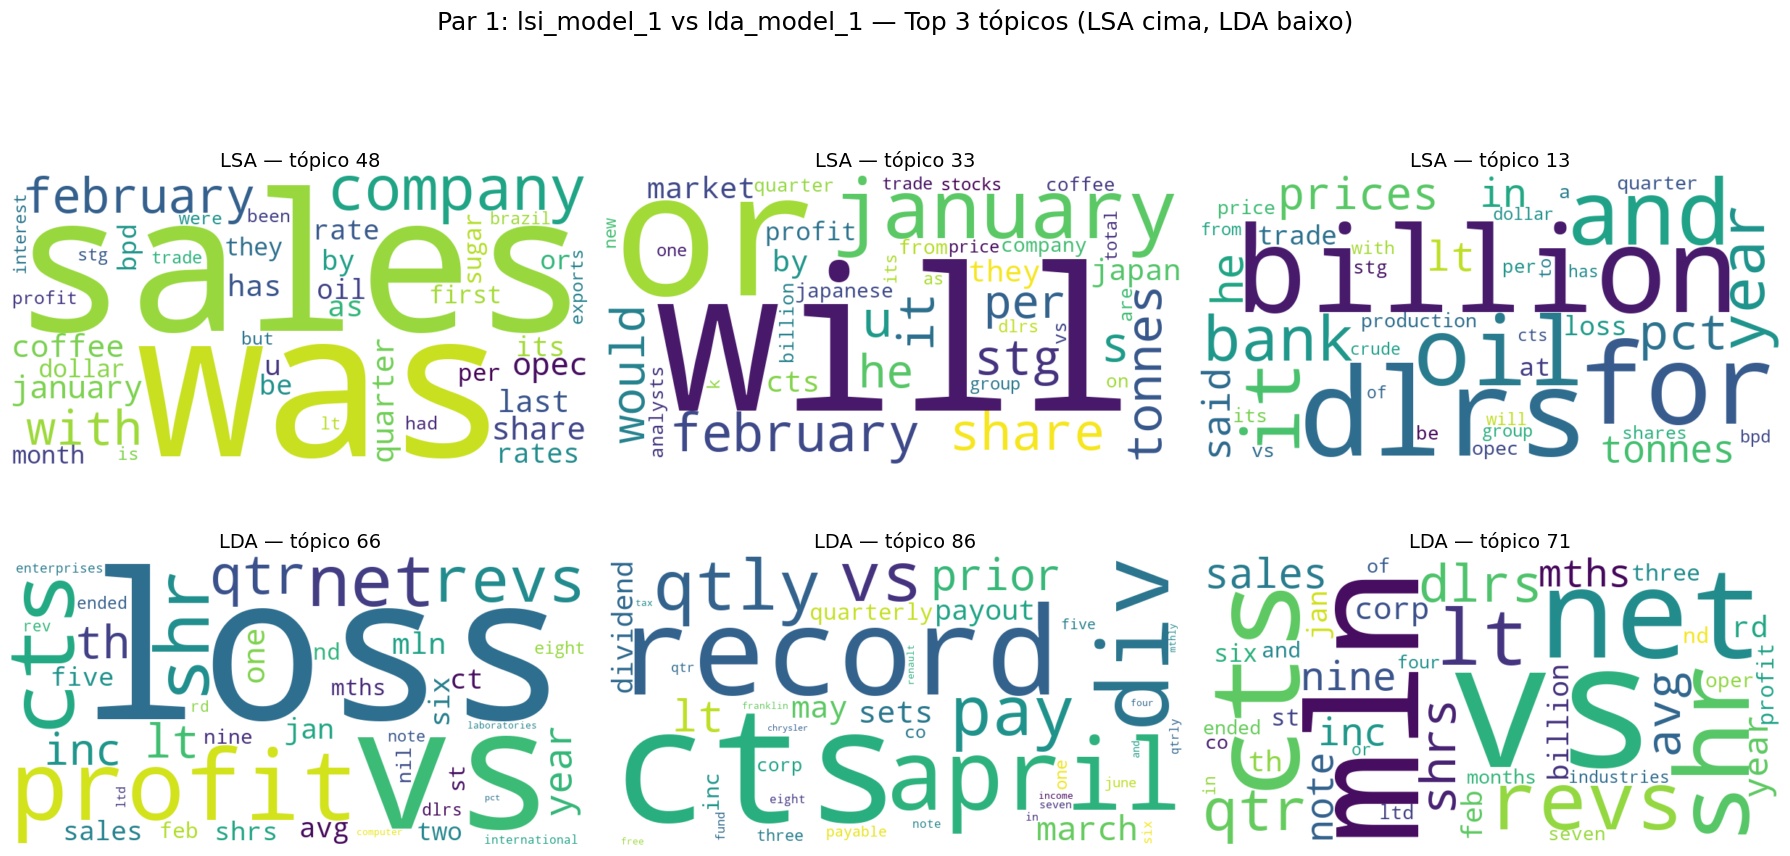

In [22]:
plot_topic_pair_wordclouds(lsi_model_1, lda_model_1, dictionary, title_prefix="Par 1: lsi_model_1 vs lda_model_1")

### Modelo 1.1 com TF-IDF

In [23]:
tfidf = TfidfModel(doc_term_matrix)
doc_term_tfidf = tfidf[doc_term_matrix]

#### LSA

In [24]:
lsi_model_1_tfidf= LSA_model(doc_term_tfidf)

In [25]:
for i, topic in lsi_model_1_tfidf.print_topics(num_topics=10):
    print(f"Tópico {i}: {topic}")

Tópico 0: 0.609*"vs" + 0.308*"loss" + 0.304*"cts" + 0.281*"net" + 0.248*"mln" + 0.221*"shr" + 0.178*"profit" + 0.177*"revs" + 0.141*"qtr" + 0.121*"dlrs"
Tópico 1: 0.335*"the" + 0.171*"to" + 0.161*"pct" + 0.160*"in" + 0.141*"billion" + 0.140*"a" + 0.134*"s" + -0.133*"vs" + 0.128*"of" + 0.125*"said"
Tópico 2: -0.752*"loss" + -0.299*"profit" + 0.206*"vs" + 0.205*"cts" + 0.175*"div" + 0.174*"qtly" + 0.141*"record" + 0.127*"pay" + 0.123*"prior" + 0.122*"april"
Tópico 3: 0.329*"qtly" + 0.323*"loss" + 0.311*"div" + 0.269*"record" + 0.246*"prior" + 0.246*"pay" + 0.238*"cts" + 0.231*"april" + -0.209*"billion" + -0.197*"mln"
Tópico 4: -0.478*"billion" + -0.332*"stg" + -0.208*"bank" + -0.174*"money" + -0.146*"loss" + -0.144*"pct" + -0.126*"january" + -0.126*"february" + 0.125*"oper" + -0.119*"profit"
Tópico 5: -0.479*"oper" + 0.371*"stg" + -0.339*"billion" + -0.234*"dlrs" + 0.151*"bank" + -0.136*"excludes" + -0.130*"february" + -0.126*"january" + 0.126*"market" + 0.116*"money"
Tópico 6: -0.577*"o

In [26]:
coherence_model_lsa = CoherenceModel(model=lsi_model_1_tfidf, texts=documents, dictionary=dictionary, coherence='c_v')
coherence_lsa = coherence_model_lsa.get_coherence()
print('Coherence Score: ', coherence_lsa)

Coherence Score:  0.3247081047844507


#### LDA

In [27]:
lda_model_1_tfidf = LDA_model(doc_term_tfidf)

In [28]:
for topic_id in range(10):
    topic_str = lda_model_1_tfidf.print_topic(topic_id, topn=10)
    print(f"Tópico {topic_id}: {topic_str}\n")

Tópico 0: 0.013*"nine" + 0.010*"billion" + 0.010*"cts" + 0.010*"ltd" + 0.010*"oil" + 0.009*"the" + 0.009*"dlrs" + 0.008*"pacific" + 0.008*"rd" + 0.008*"debt"

Tópico 1: 0.025*"workers" + 0.020*"employers" + 0.016*"pakistan" + 0.014*"port" + 0.011*"unions" + 0.008*"redundancies" + 0.008*"strikes" + 0.008*"fnv" + 0.007*"rotterdam" + 0.007*"workforce"

Tópico 2: 0.035*"deficit" + 0.021*"coffee" + 0.015*"deposit" + 0.012*"bags" + 0.012*"cooperate" + 0.012*"billion" + 0.010*"semi" + 0.008*"account" + 0.008*"combined" + 0.007*"trade"

Tópico 3: 0.016*"the" + 0.012*"he" + 0.012*"trade" + 0.009*"that" + 0.009*"u" + 0.008*"to" + 0.007*"s" + 0.007*"would" + 0.007*"gold" + 0.006*"deficit"

Tópico 4: 0.030*"refinery" + 0.029*"gasoline" + 0.022*"off" + 0.020*"distillate" + 0.018*"stocks" + 0.017*"api" + 0.017*"crude" + 0.015*"barrels" + 0.010*"bpd" + 0.008*"super"

Tópico 5: 0.004*"mellon" + 0.001*"fairly" + 0.001*"giordano" + 0.001*"schlesinger" + 0.000*"bundesbank" + 0.000*"street" + 0.000*"dolla

In [29]:
coherence_model_lda = CoherenceModel(model=lda_model_1_tfidf, texts=documents, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('LDA Coherence Score:', coherence_lda)

LDA Coherence Score: 0.39335021246324636


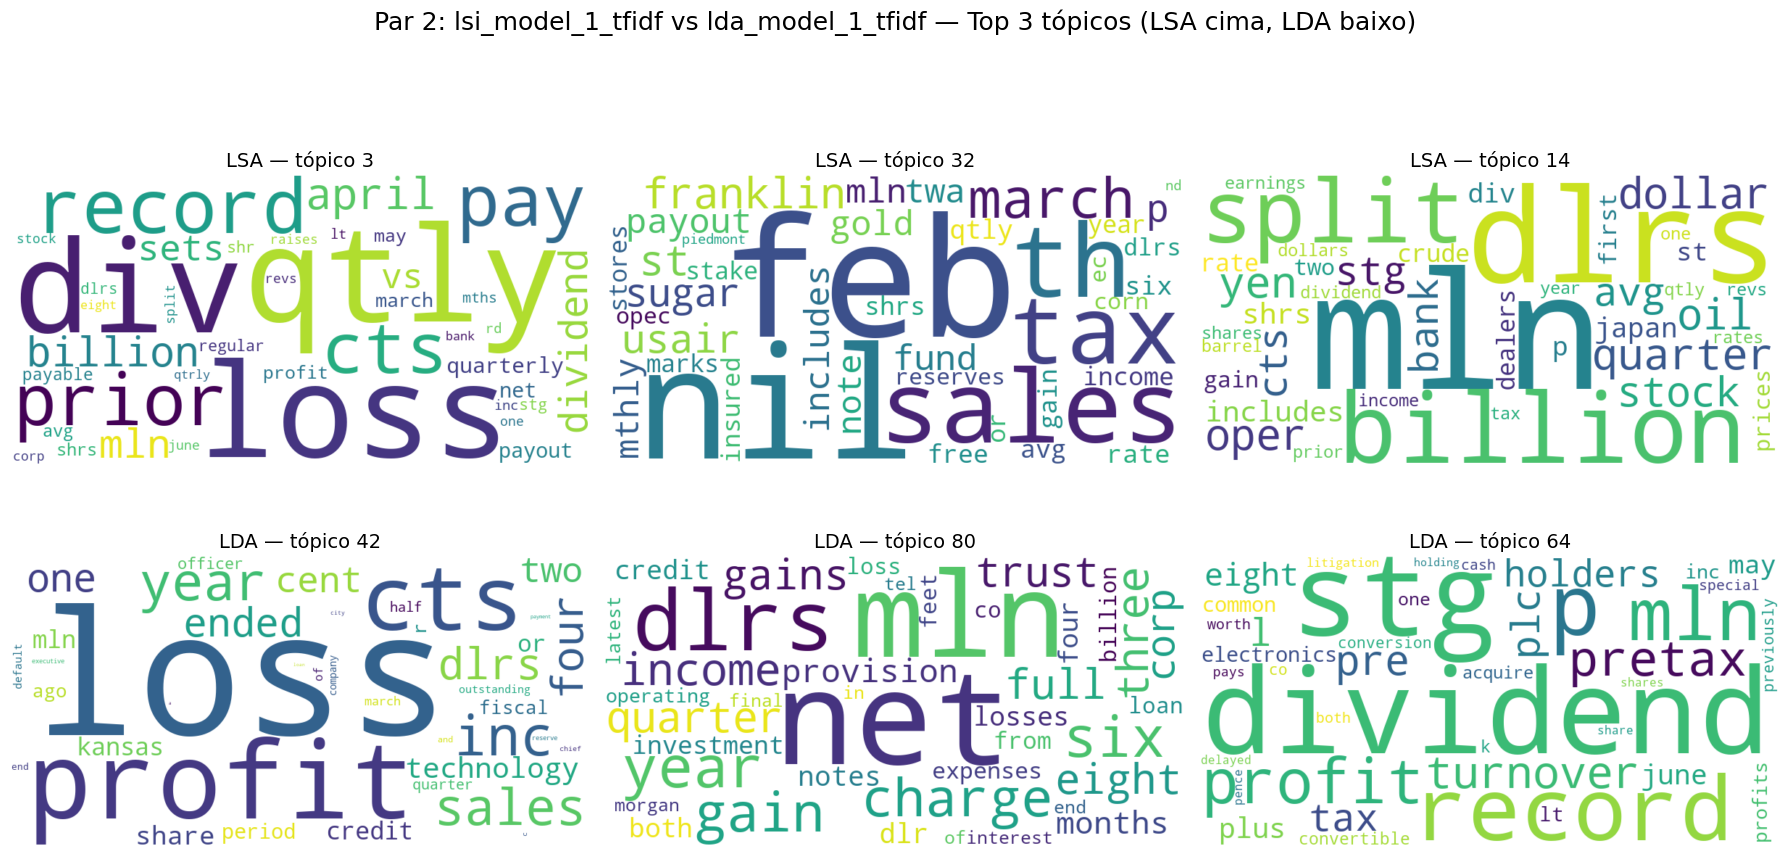

In [30]:
plot_topic_pair_wordclouds(lsi_model_1_tfidf, lda_model_1_tfidf, dictionary, title_prefix="Par 2: lsi_model_1_tfidf vs lda_model_1_tfidf")

### Modelo 2

Removing stopwords, and stemming

In [31]:
def preprocess_data(doc_set):
    en_stop = set(stopwords.words('english'))
    p_stemmer = PorterStemmer()
    texts = []
    for tokens in doc_set:
        stopped_tokens = [i for i in tokens if not i in en_stop]
        stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]
        texts.append(stemmed_tokens)
    return texts

In [32]:
documents_stem = preprocess_data(documents)

In [33]:
dictionary_stem = Dictionary(documents_stem)
doc_term_stem = [dictionary_stem.doc2bow(doc) for doc in documents_stem]

#### LSA

In [46]:
lsi_model_2 = LSA_model(doc_term_stem,90,dictionary_stem)

In [47]:
for i, topic in lsi_model_2.print_topics(num_topics=10):
    print(f"Tópico {i}: {topic}")

Tópico 0: 0.529*"said" + 0.382*"mln" + 0.298*"dlr" + 0.201*"pct" + 0.190*"vs" + 0.185*"year" + 0.134*"u" + 0.130*"billion" + 0.115*"lt" + 0.110*"would"
Tópico 1: 0.529*"vs" + 0.442*"mln" + -0.384*"said" + 0.226*"ct" + 0.213*"net" + 0.189*"shr" + 0.176*"loss" + 0.143*"dlr" + -0.131*"pct" + -0.116*"u"
Tópico 2: 0.903*"nil" + 0.172*"prev" + 0.168*"wk" + 0.147*"e" + -0.097*"dlr" + 0.088*"c" + 0.085*"total" + 0.076*"export" + 0.063*"p" + 0.063*"name"
Tópico 3: -0.458*"dlr" + 0.412*"vs" + -0.337*"mln" + 0.249*"ct" + 0.204*"u" + 0.174*"shr" + 0.154*"trade" + -0.152*"billion" + -0.149*"share" + 0.137*"loss"
Tópico 4: 0.535*"pct" + -0.261*"said" + 0.252*"billion" + -0.238*"share" + -0.196*"compani" + -0.186*"dlr" + -0.182*"lt" + 0.181*"bank" + 0.178*"rate" + 0.174*"year"
Tópico 5: 0.569*"mln" + -0.340*"pct" + -0.282*"dlr" + 0.199*"tonn" + -0.189*"ct" + -0.161*"billion" + -0.161*"share" + 0.149*"u" + -0.147*"bank" + -0.144*"loss"
Tópico 6: 0.438*"pct" + -0.432*"dlr" + -0.408*"billion" + -0.253*"

In [48]:
coherence_model_lsa = CoherenceModel(model=lsi_model_2, texts=documents_stem, dictionary=dictionary_stem, coherence='c_v')
coherence_lsa = coherence_model_lsa.get_coherence()
print('Coherence Score: ', coherence_lsa)

Coherence Score:  0.255117429641255


#### LDA

In [49]:
lda_model_2 = LDA_model(doc_term_stem,90,dictionary_stem)

In [50]:
for topic_id in range(10):
    topic_str = lda_model_2.print_topic(topic_id, topn=10)
    print(f"Tópico {topic_id}: {topic_str}\n")

Tópico 0: 0.114*"china" + 0.061*"billion" + 0.053*"surplu" + 0.051*"deficit" + 0.037*"trade" + 0.036*"ventur" + 0.030*"joint" + 0.028*"export" + 0.028*"itali" + 0.023*"freight"

Tópico 1: 0.101*"sugar" + 0.058*"coffe" + 0.049*"quota" + 0.041*"export" + 0.028*"produc" + 0.026*"brazil" + 0.020*"world" + 0.020*"indonesia" + 0.019*"said" + 0.013*"import"

Tópico 2: 0.075*"split" + 0.052*"stock" + 0.049*"said" + 0.035*"two" + 0.025*"resourc" + 0.025*"compani" + 0.022*"one" + 0.021*"set" + 0.021*"record" + 0.020*"lt"

Tópico 3: 0.044*"estat" + 0.036*"said" + 0.028*"newmont" + 0.022*"real" + 0.022*"heller" + 0.014*"philip" + 0.012*"mln" + 0.012*"compani" + 0.011*"crosbi" + 0.009*"hanov"

Tópico 4: 0.083*"oil" + 0.033*"said" + 0.032*"dlr" + 0.026*"barrel" + 0.020*"shell" + 0.016*"price" + 0.015*"energi" + 0.013*"fuel" + 0.013*"crude" + 0.012*"mln"

Tópico 5: 0.160*"dlr" + 0.108*"billion" + 0.058*"mln" + 0.034*"week" + 0.021*"rose" + 0.020*"reserv" + 0.018*"u" + 0.017*"said" + 0.014*"fell" + 0.

In [51]:
coherence_model_lda = CoherenceModel(model=lda_model_2, texts=documents_stem, dictionary=dictionary_stem, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Coherence Score:  0.41983085678550175


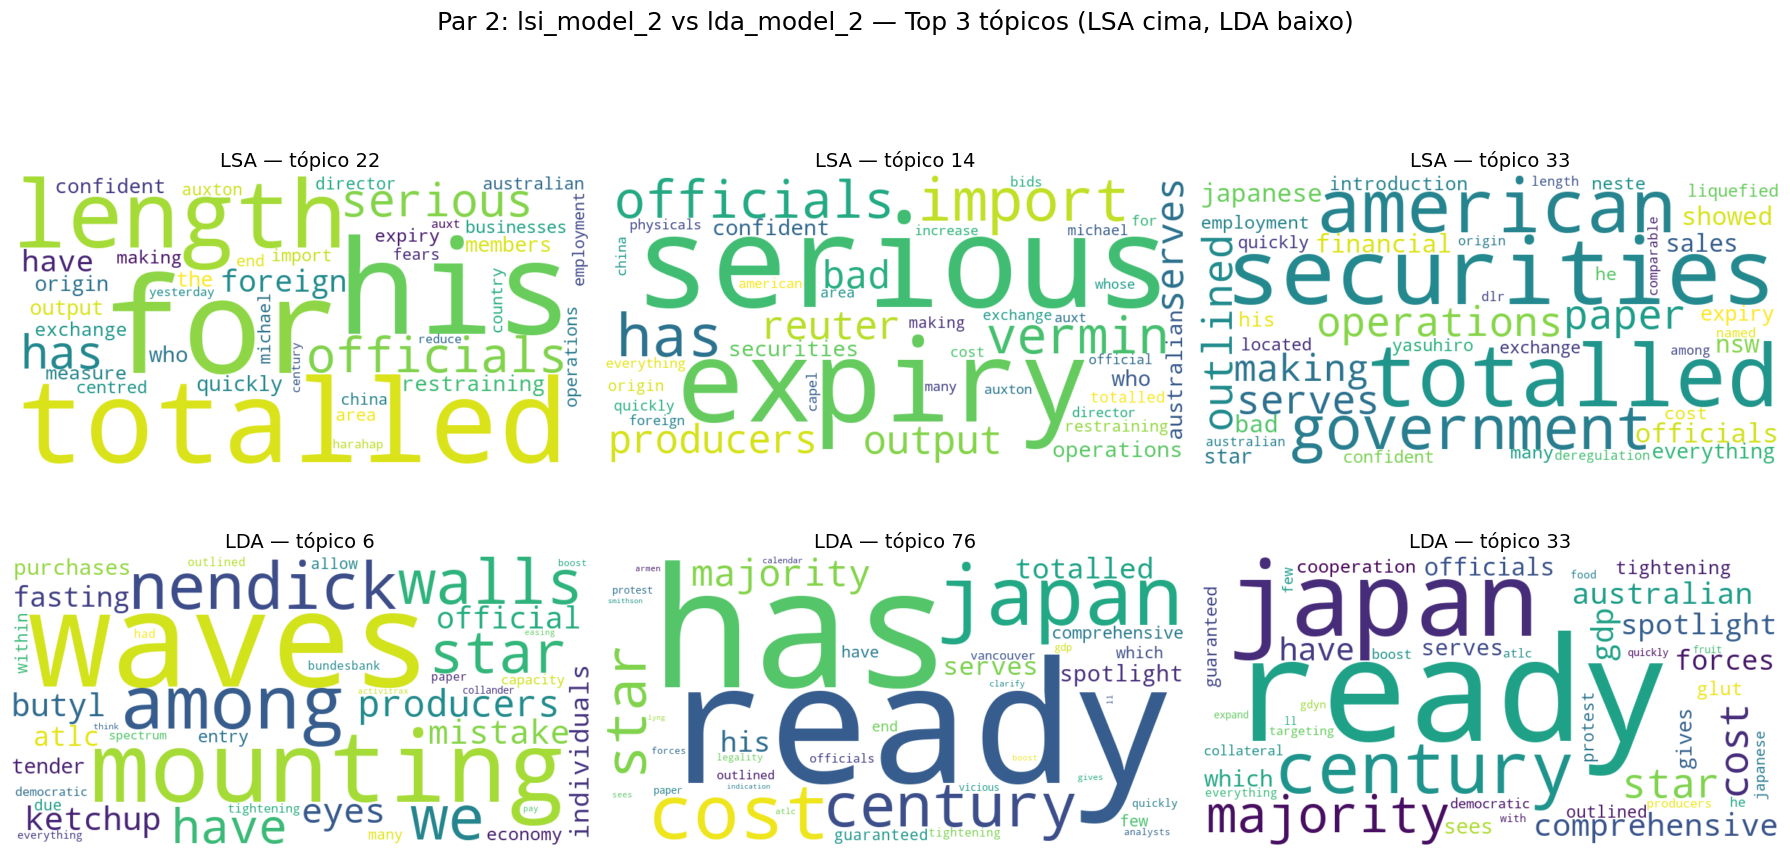

In [67]:
plot_topic_pair_wordclouds(lsi_model_2, lda_model_2, dictionary, title_prefix="Par 2: lsi_model_2 vs lda_model_2")

### Modelo 2.1 com TF-IDF

In [52]:
tfidf_2 = TfidfModel(doc_term_stem)
doc_term_stem_tfidf = tfidf_2[doc_term_stem]

#### LSA

In [68]:
 lsi_model_2_tfidf = LSA_model(doc_term_stem_tfidf,90,dictionary_stem)

In [69]:
for i, topic in lsi_model_2_tfidf.print_topics(num_topics=10):
    print(f"Tópico {i}: {topic}")

Tópico 0: 0.609*"vs" + 0.311*"ct" + 0.300*"loss" + 0.283*"net" + 0.281*"shr" + 0.248*"mln" + 0.179*"rev" + 0.168*"profit" + 0.142*"qtr" + 0.123*"dlr"
Tópico 1: 0.227*"billion" + 0.221*"pct" + 0.206*"bank" + 0.146*"u" + 0.144*"rate" + 0.141*"said" + 0.122*"trade" + -0.122*"vs" + 0.113*"market" + 0.113*"dlr"
Tópico 2: -0.758*"loss" + -0.285*"profit" + 0.209*"ct" + 0.200*"vs" + 0.181*"qtli" + 0.181*"div" + 0.139*"record" + 0.128*"pay" + 0.126*"prior" + 0.124*"april"
Tópico 3: -0.340*"loss" + -0.322*"qtli" + -0.303*"div" + -0.256*"record" + -0.242*"ct" + -0.240*"prior" + -0.236*"pay" + 0.231*"billion" + -0.228*"april" + 0.196*"mln"
Tópico 4: -0.362*"stg" + -0.335*"billion" + 0.303*"tonn" + -0.274*"bank" + -0.191*"money" + 0.138*"export" + 0.133*"wheat" + -0.123*"loss" + 0.115*"oil" + -0.104*"fed"
Tópico 5: 0.531*"billion" + -0.434*"stg" + -0.199*"bank" + 0.168*"februari" + 0.166*"dlr" + 0.162*"januari" + -0.149*"market" + -0.137*"money" + -0.130*"bill" + -0.118*"england"
Tópico 6: 0.345*"s

In [70]:
coherence_model_lsa = CoherenceModel(model=lsi_model_2_tfidf, texts=documents_stem, dictionary=dictionary_stem, coherence='c_v')
coherence_lsa = coherence_model_lsa.get_coherence()
print('Coherence Score: ', coherence_lsa)

Coherence Score:  0.3183460253679757


#### LDA

In [59]:
lda_model_2_tfidf = LDA_model(doc_term_stem_tfidf,90,dictionary_stem)

In [60]:
for topic_id in range(10):
    topic_str = lda_model_2_tfidf.print_topic(topic_id, topn=10)
    print(f"Tópico {topic_id}: {topic_str}\n")

Tópico 0: 0.000*"genecor" + 0.000*"additivi" + 0.000*"rejuven" + 0.000*"nineth" + 0.000*"citybank" + 0.000*"zahnradfabrik" + 0.000*"triennial" + 0.000*"steinkuehl" + 0.000*"passau" + 0.000*"obstinaci"

Tópico 1: 0.047*"interven" + 0.004*"robin" + 0.004*"pemberton" + 0.004*"leigh" + 0.002*"asset" + 0.001*"excess" + 0.001*"nine" + 0.001*"return" + 0.001*"prepar" + 0.001*"favour"

Tópico 2: 0.006*"auto" + 0.001*"vancouv" + 0.001*"pact" + 0.001*"canadian" + 0.000*"harmoni" + 0.000*"free" + 0.000*"fraser" + 0.000*"trade" + 0.000*"vulner" + 0.000*"tie"

Tópico 3: 0.007*"miller" + 0.001*"chief" + 0.001*"overreact" + 0.001*"concern" + 0.001*"soup" + 0.000*"caus" + 0.000*"white" + 0.000*"jame" + 0.000*"hous" + 0.000*"budget"

Tópico 4: 0.023*"yen" + 0.021*"buy" + 0.019*"group" + 0.015*"inc" + 0.015*"dealer" + 0.015*"propos" + 0.014*"ltd" + 0.014*"merg" + 0.014*"bid" + 0.013*"telecom"

Tópico 5: 0.068*"februari" + 0.056*"pct" + 0.043*"billion" + 0.043*"rose" + 0.036*"revis" + 0.034*"fell" + 0.03

In [95]:
coherence_model_lda = CoherenceModel(model=lda_model_2_tfidf, texts=documents_stem, dictionary=dictionary_stem, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Coherence Score:  0.40671873853353446


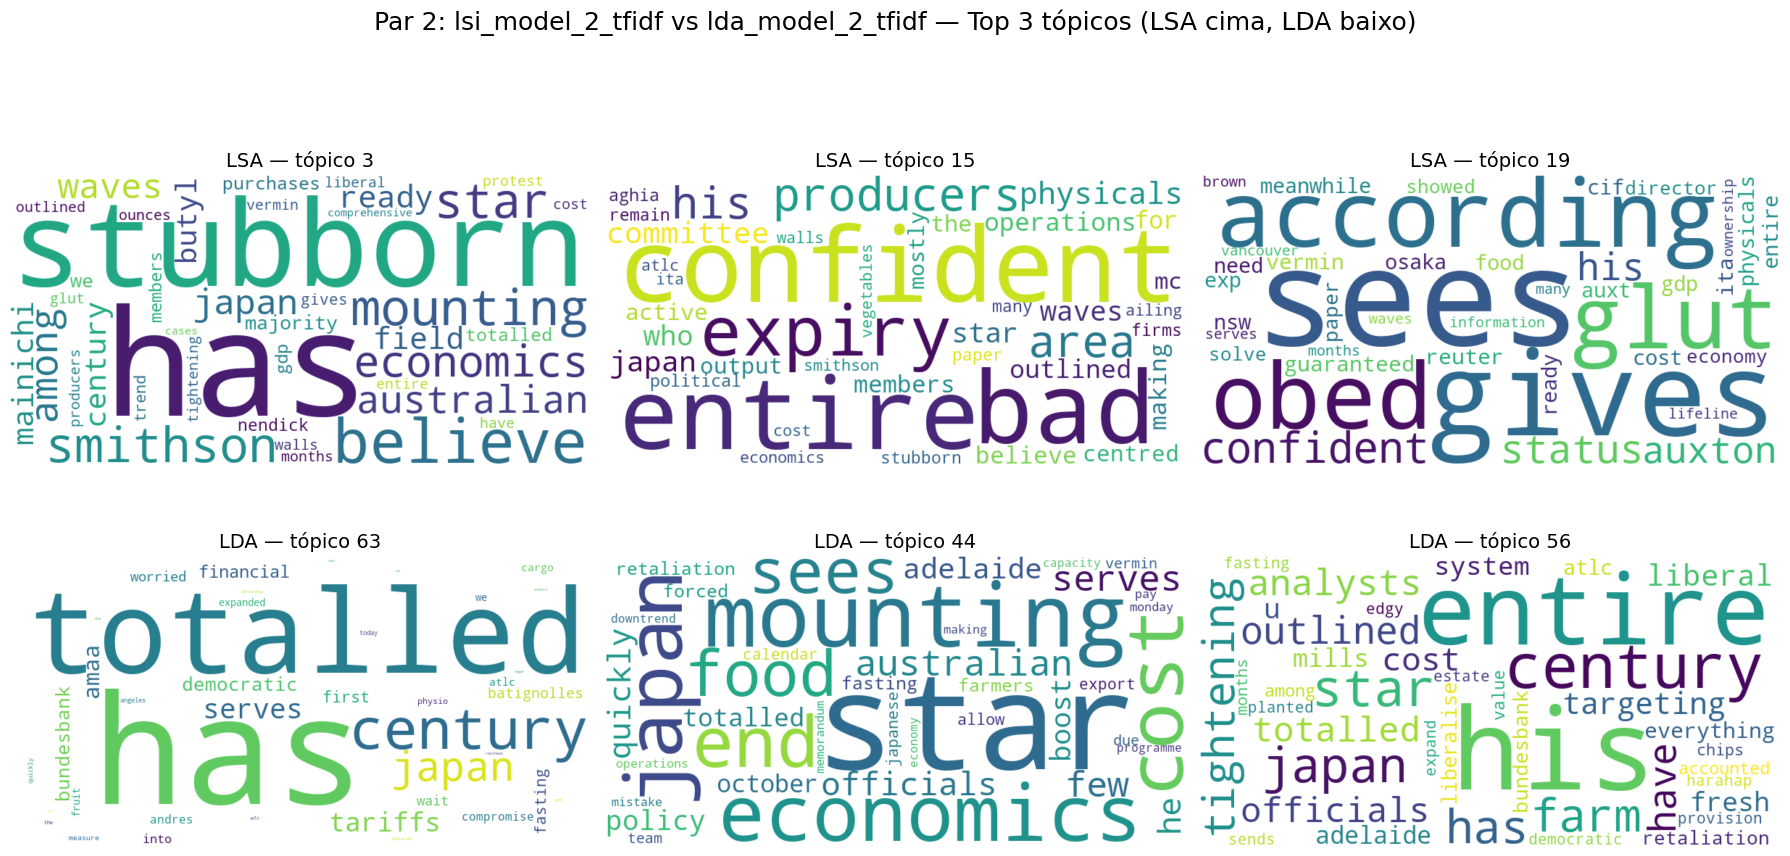

In [71]:
plot_topic_pair_wordclouds(lsi_model_2_tfidf, lda_model_2_tfidf, dictionary, title_prefix="Par 2: lsi_model_2_tfidf vs lda_model_2_tfidf")

### Modelo 3

Removing stopwords, and lemmatization and relevant words (Pos tagging)

In [64]:
def preprocess_data_LSA_2(doc_set):
    nlp = spacy.load("en_core_web_sm")
    en_stop = set(stopwords.words('english'))
    texts = []
    for tokens in doc_set:
        doc = nlp(" ".join(tokens))
        lemmas = [
            token.lemma_.lower()
            for token in doc
            if token.lemma_.lower() not in en_stop  
            and token.pos_ in ("NOUN", "PROPN", "ADJ")  
        ] 
        texts.append(lemmas)
    return texts

In [72]:
nlp = spacy.load("en_core_web_sm")
en_stop = set(stopwords.words('english'))

def preprocess_data_LSA_2_1(doc_set, bigram_flag, min_len=0):
    texts = []
    for tokens in doc_set:
        doc = nlp(" ".join(tokens))
        lemmas = [
            token.lemma_.lower()
            for token in doc
            if token.lemma_.lower() not in en_stop  
            and token.pos_ in ("NOUN", "PROPN", "ADJ")  
        ] 
        if len(lemmas) >= min_len:
            texts.append(lemmas)
    
    if bigram_flag:
        bigram = Phrases(texts, min_count=5, threshold=15)
        bigram_mod = Phraser(bigram)
        texts = [bigram_mod[doc] for doc in texts]
        
    return texts

In [73]:
documents_lemma = preprocess_data_LSA_2_1(documents, 1, 10)

In [74]:
dictionary_lemma = Dictionary(documents_lemma)
doc_term_lemma = [dictionary_lemma.doc2bow(doc) for doc in documents_lemma]

#### LSA

In [75]:
lsi_model_3 = LSA_model(doc_term_lemma, 90, dictionary_lemma)

In [76]:
for i, topic in lsi_model_3.print_topics(num_topics=10):
    print(f"Tópico {i}: {topic}")

Tópico 0: 0.586*"mln" + 0.486*"dlrs" + 0.230*"year" + 0.217*"pct" + 0.184*"loss" + 0.160*"net" + 0.154*"share" + 0.140*"company" + 0.115*"profit" + 0.101*"price"
Tópico 1: 0.482*"mln" + -0.432*"pct" + 0.216*"loss" + -0.206*"u" + -0.186*"price" + -0.173*"market" + -0.158*"bank" + 0.156*"net" + -0.148*"year" + -0.113*"japan"
Tópico 2: 0.652*"dlrs" + -0.510*"mln" + 0.228*"share" + -0.186*"tonne" + 0.173*"company" + -0.169*"pct" + 0.112*"loss" + 0.077*"lt" + -0.076*"production" + -0.075*"export"
Tópico 3: 0.636*"pct" + 0.270*"loss" + -0.246*"u" + -0.165*"market" + 0.163*"january" + -0.150*"price" + 0.147*"profit" + 0.142*"ct" + 0.140*"february" + -0.135*"tonne"
Tópico 4: 0.580*"loss" + 0.279*"ct" + -0.246*"mln" + -0.228*"share" + 0.226*"profit" + 0.221*"u" + -0.216*"pct" + 0.182*"net" + -0.172*"company" + 0.149*"japan"
Tópico 5: -0.467*"dlrs" + 0.430*"share" + 0.411*"company" + 0.198*"lt" + 0.191*"loss" + -0.176*"bank" + 0.160*"ct" + 0.149*"profit" + 0.132*"price" + 0.131*"stock"
Tópico 6:

In [77]:
coherence_model_lsa = CoherenceModel(model=lsi_model_3, texts=documents_lemma, dictionary=dictionary_lemma, coherence='c_v')
coherence_lsa = coherence_model_lsa.get_coherence()
print('Coherence Score: ', coherence_lsa)

Coherence Score:  0.2885544246820858


#### LDA

In [78]:
lda_model_3 = LDA_model(doc_term_lemma, 90, dictionary_lemma)

In [79]:
for topic_id in range(10):
    topic_str = lda_model_3.print_topic(topic_id, topn=10)
    print(f"Tópico {topic_id}: {topic_str}\n")

Tópico 0: 0.093*"dlrs" + 0.049*"loss" + 0.044*"first_quarter" + 0.038*"operating" + 0.032*"mln" + 0.029*"year" + 0.023*"company" + 0.022*"second_quarter" + 0.018*"flat" + 0.018*"sale"

Tópico 1: 0.079*"order" + 0.038*"survey" + 0.025*"company" + 0.019*"settlement" + 0.019*"court" + 0.017*"pct" + 0.017*"year" + 0.015*"holdings_inc" + 0.014*"gross" + 0.010*"federal"

Tópico 2: 0.146*"january" + 0.124*"february" + 0.041*"dlrs" + 0.040*"surplus" + 0.035*"deficit" + 0.035*"december" + 0.035*"mln" + 0.033*"export" + 0.033*"pct" + 0.031*"import"

Tópico 3: 0.054*"food" + 0.030*"growth" + 0.022*"industrial_nation" + 0.016*"egg" + 0.013*"expansion" + 0.012*"executive_director" + 0.012*"frozen" + 0.012*"mixed" + 0.012*"policy" + 0.012*"owen"

Tópico 4: 0.267*"mln" + 0.054*"dlrs" + 0.032*"profit" + 0.032*"net" + 0.031*"year" + 0.021*"sale" + 0.019*"tax" + 0.017*"cent" + 0.015*"turnover" + 0.009*"company"

Tópico 5: 0.079*"oil" + 0.048*"field" + 0.034*"energy" + 0.031*"southern" + 0.031*"petroleum

In [80]:
coherence_model_da = CoherenceModel(model=lda_model_3, texts=documents_lemma, dictionary=dictionary_lemma, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Coherence Score:  0.40671873853353446


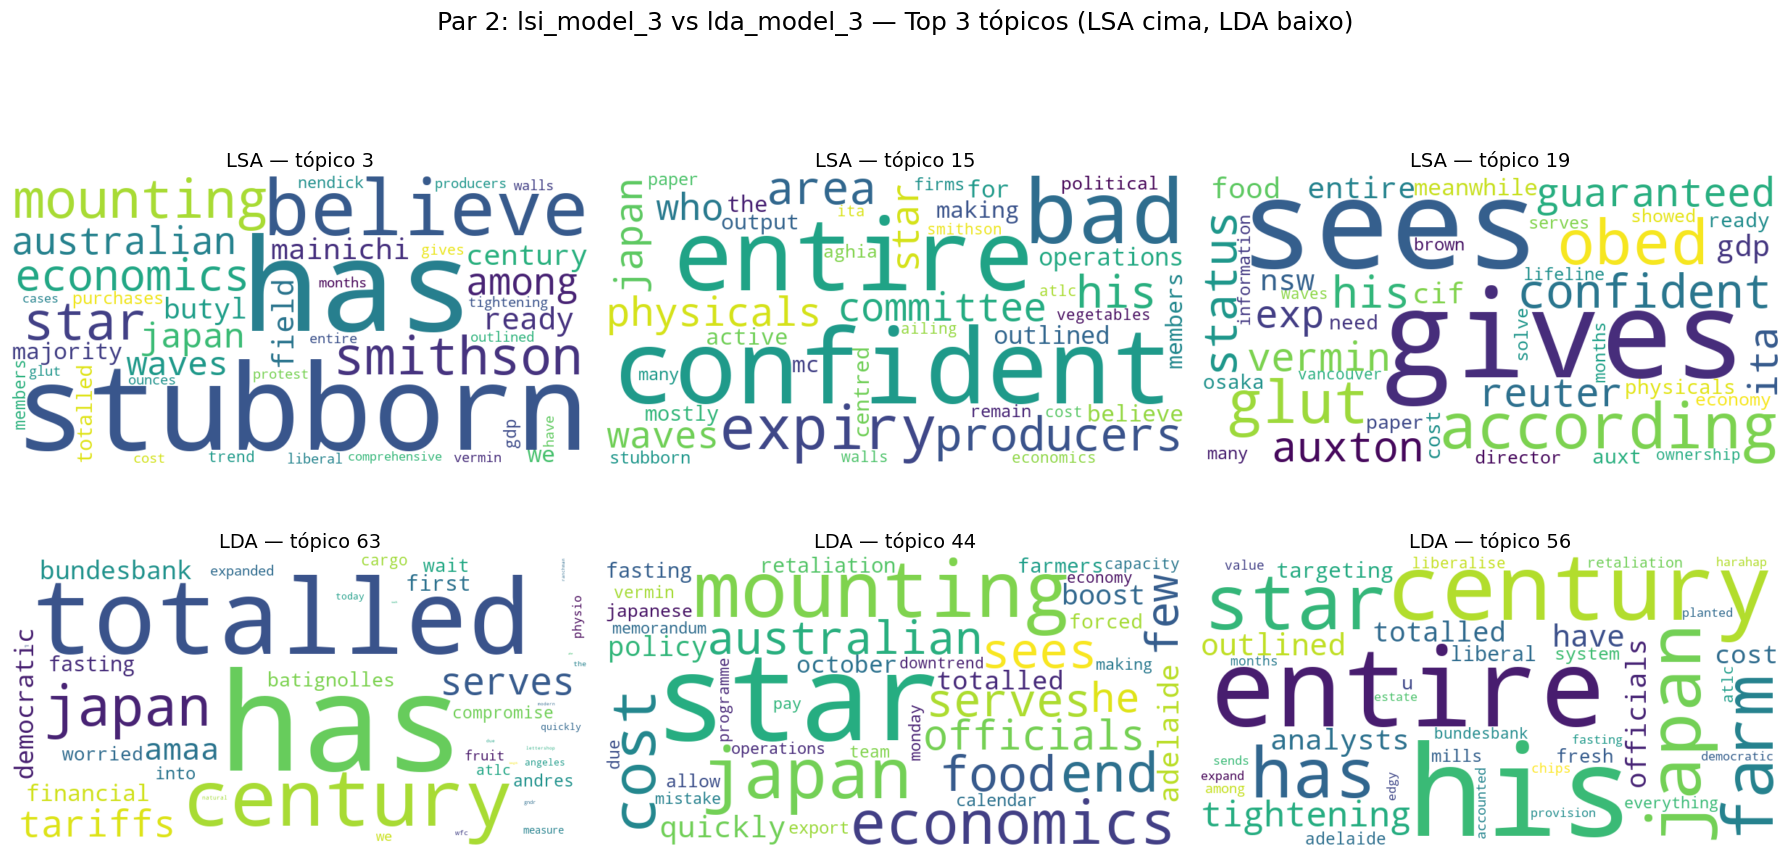

In [99]:
plot_topic_pair_wordclouds(lsi_model_2_tfidf, lda_model_2_tfidf, dictionary, title_prefix="Par 2: lsi_model_3 vs lda_model_3")

### Modelo 3.1 com TF-IDF

In [81]:
tfidf_3 = TfidfModel(doc_term_lemma)
doc_term_lemma_tfidf = tfidf_2[doc_term_lemma]

#### LSA

In [88]:
lsi_model_3_tfidf = LSA_model(doc_term_lemma_tfidf, 90, dictionary_lemma)

In [89]:
for i, topic in lsi_model_3_tfidf.print_topics(num_topics=10):
    print(f"Tópico {i}: {topic}")

Tópico 0: 0.632*"mln" + 0.511*"net" + 0.252*"dlrs" + 0.213*"ct" + 0.202*"loss" + 0.198*"profit" + 0.159*"shr" + 0.125*"cts_net" + 0.106*"year" + 0.101*"revs"
Tópico 1: 0.530*"mln" + -0.445*"ct" + -0.390*"loss" + -0.383*"profit" + -0.262*"net" + -0.190*"shr" + 0.122*"cts_net" + 0.115*"pct" + 0.101*"dlrs" + 0.081*"tonne"
Tópico 2: 0.399*"dlrs" + 0.348*"share" + 0.311*"pct" + -0.253*"mln" + -0.191*"net" + -0.186*"cts_net" + 0.166*"year" + 0.159*"stock" + 0.147*"march" + 0.144*"bank"
Tópico 3: 0.450*"net" + -0.405*"mln" + -0.368*"profit" + 0.315*"dlrs" + 0.244*"share" + 0.243*"cts_net" + -0.215*"loss" + 0.189*"shr_ct" + -0.156*"ct" + -0.146*"tonne"
Tópico 4: 0.464*"share" + -0.346*"net" + -0.330*"pct" + 0.219*"mln" + -0.194*"february" + 0.191*"dlrs" + -0.178*"january" + -0.178*"bank" + -0.167*"year" + -0.141*"cts_net"
Tópico 5: -0.638*"dlrs" + 0.346*"share" + 0.303*"ct" + -0.212*"loss" + 0.198*"stock" + 0.193*"dividend" + 0.184*"cts_net" + 0.175*"pct" + 0.160*"shr_ct" + 0.128*"march"
Tópic

In [90]:
coherence_model_lsa = CoherenceModel(model=lsi_model_3_tfidf, texts=documents_lemma, dictionary=dictionary_lemma, coherence='c_v')
coherence_lsa = coherence_model_lsa.get_coherence()
print('Coherence Score: ', coherence_lsa)

Coherence Score:  0.3444186799651455


#### LDA

In [96]:
lda_model_3_tfidf = LDA_model(doc_term_lemma_tfidf, 90, dictionary_lemma)

In [97]:
for topic_id in range(10):
    topic_str = lda_model_3_tfidf.print_topic(topic_id, topn=10)
    print(f"Tópico {topic_id}: {topic_str}\n")

Tópico 0: 0.000*"ute" + 0.000*"triennial" + 0.000*"steinkuehler" + 0.000*"passau" + 0.000*"obstinacy" + 0.000*"metalworker" + 0.000*"metall" + 0.000*"messerschmitt" + 0.000*"ig" + 0.000*"humiliation"

Tópico 1: 0.076*"bank" + 0.068*"dealer" + 0.067*"dollar_yen" + 0.040*"new_york" + 0.037*"dollar" + 0.018*"tokyo" + 0.018*"japan" + 0.012*"attack" + 0.010*"selling" + 0.008*"campbell"

Tópico 2: 0.000*"ute" + 0.000*"triennial" + 0.000*"steinkuehler" + 0.000*"passau" + 0.000*"obstinacy" + 0.000*"metalworker" + 0.000*"metall" + 0.000*"messerschmitt" + 0.000*"ig" + 0.000*"humiliation"

Tópico 3: 0.000*"ute" + 0.000*"triennial" + 0.000*"steinkuehler" + 0.000*"passau" + 0.000*"obstinacy" + 0.000*"metalworker" + 0.000*"metall" + 0.000*"messerschmitt" + 0.000*"ig" + 0.000*"humiliation"

Tópico 4: 0.029*"indicator" + 0.025*"industrial_production" + 0.025*"pct" + 0.014*"housing" + 0.011*"activity" + 0.010*"commerce_department" + 0.009*"job" + 0.008*"housing_start" + 0.007*"lumber" + 0.007*"annual"


In [98]:
coherence_model_lda = CoherenceModel(model=lda_model_3_tfidf, texts=documents_lemma, dictionary=dictionary_lemma,
                                     coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Coherence Score:  0.4243026197860763


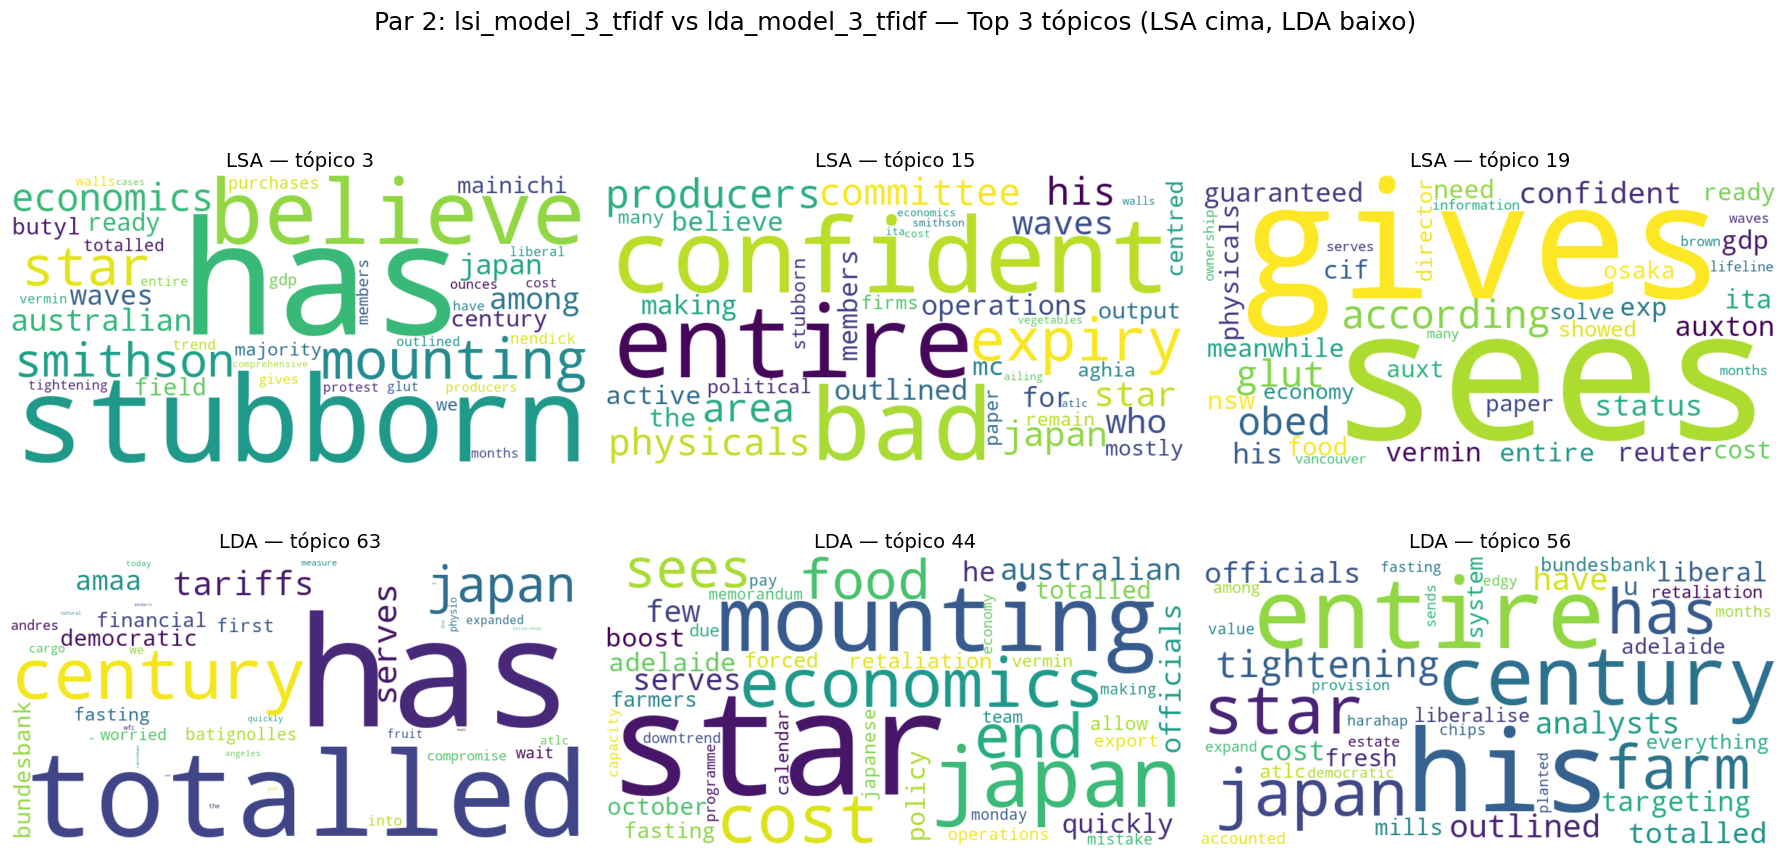

In [100]:
plot_topic_pair_wordclouds(lsi_model_2_tfidf, lda_model_2_tfidf, dictionary, title_prefix="Par 2: lsi_model_3_tfidf vs lda_model_3_tfidf")